# Characterizing Distributions of Generated Molecules

## Configuration

In [125]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # set gpu

cwd = os.getcwd()
print('Working directory:', cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
Working directory: /home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [210]:
import numpy as np
from numpy.linalg import norm

import pandas as pd

from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
import useful_rdkit_utils as uru

import pickle

from molscore import MolScore
from moleval.metrics.metrics import GetMetrics

from fcd import get_fcd

import medchem as mc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_validate

In [127]:
#Seaborn settings for visualizations

rc = {
    "axes.facecolor": "#f7f9fc",
    "figure.facecolor": "#f7f9fc",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

default_palette = 'YlOrRd'

sns.set(rc=rc)
pd.set_option('display.max_columns',35)
pd.options.display.float_format = '{:,.2f}'.format

In [128]:
# Set pandas display options to improve readability

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

In [129]:
fragments = []

f = open("data/fragments.smi", "r")

for i in range(1, 51):
    mol = f.readline()
    fragments.append(mol[:-1])

In [130]:
models = ['reinvent', 'crem', 'coati', 'safe']

## Generating Data

In [131]:
# %%capture

# reinvent_distributions, crem_distributions, coati_distributions, safe_distributions = [], [], [], []

# for fragment in fragments:
#     for model in models:

#         DF_FILEPATH = f'data/{model}_dataframe.csv'

#         arg1 = '--model'
#         arg2 = '--input_frag'
#         arg3 = '--sample'

#         args = ['python3', 'generate_analogs.py',
#                 arg1, model,
#                 arg2, fragment,
#                 arg3, '200']

#         # Change directory to generate analogs with python script
#         %cd ..

#         subprocess.run(args,
#                     stdout=subprocess.DEVNULL,
#                     stderr=subprocess.STDOUT)
                
#         # Change directory back to that of the current notebook
#         %cd experiments

#         df = pd.read_csv(DF_FILEPATH, index_col=0)

#         df['Model'] = model

#         if model == 'reinvent':
#             reinvent_distributions.append(df)
#         elif model == 'crem':
#             crem_distributions.append(df)
#         elif model == 'coati':
#             coati_distributions.append(df)
#         elif model == 'safe':
#             safe_distributions.append(df)

In [132]:
# data = {'reinvent' : reinvent_distributions,
#         'crem' : crem_distributions,
#         'coati' : coati_distributions,
#         'safe' : safe_distributions}

In [133]:
# with open('lists.pkl', 'wb') as file:
#     pickle.dump(data, file)

In [134]:
with open('lists.pkl', 'rb') as file:
    data = pickle.load(file)

In [135]:
reinvent_distributions = data['reinvent']
crem_distributions = data['crem']
coati_distributions = data['coati']
safe_distributions = data['safe']

In [136]:
for d in data:

    for i, df in enumerate(data[d]):

        df['Input Fragment'] = fragments[i]

## Defining Utils

In [137]:
def sparse_int_vect_to_numpy(sparse_vect, length):
    array = np.zeros(length, dtype=int)
    for idx, value in sparse_vect.GetNonzeroElements().items():
        array[idx] = value
    return array

In [138]:
def remove_odd_rings(df):

    ring_system_lookup = uru.RingSystemLookup.default()
    df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)
    df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()

    odd_rings = df['min_freq'] < 100

    df['Odd rings'] = ~ odd_rings

    df = df[df['Odd rings']].drop(columns=['Odd rings'])
    
    return df.loc[:, ['SMILES', 'Model', 'Input Fragment']]

In [139]:
def compute_fcd(fragment, smiles): 
    frag_mol = Chem.MolFromSmiles(fragment)
    canon_frag = Chem.MolToSmiles(frag_mol)

    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    canon_smiles = [Chem.MolToSmiles(mol) for mol in mols]

    fcd = get_fcd(canon_frag, canon_smiles)

    return fcd

In [140]:
def tanimoto_similarity(smi_1, smi_2):
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,countSimulation=True)
    mol_1 = Chem.MolFromSmiles(smi_1)
    mol_2 = Chem.MolFromSmiles(smi_2)
    
    fp_1 = rdFingerprintGenerator.GetCountFPs([mol_1])[0]
    fp_2 = rdFingerprintGenerator.GetCountFPs([mol_2])[0]
        
    return DataStructs.TanimotoSimilarity(fp_1, fp_2)

In [141]:
def cosine_similarity(smi_1, smi_2):
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,countSimulation=True)
    mol_1 = Chem.MolFromSmiles(smi_1)
    mol_2 = Chem.MolFromSmiles(smi_2)
    
    fp1 = rdFingerprintGenerator.GetCountFPs([mol_1])[0]
    fp2 = rdFingerprintGenerator.GetCountFPs([mol_2])[0]

    A = sparse_int_vect_to_numpy(fp1, 2048)
    B = sparse_int_vect_to_numpy(fp2, 2048)

    return np.dot(A, B) / (norm(A) * norm(B))

In [142]:
def compute_similarities(fragment, smiles):

    size = len(smiles)
    snn = 0
    avg_tanimoto = 0
    avg_cosine = 0

    for smile in smiles:

        tanimoto = tanimoto_similarity(fragment, smile)
        cosine = cosine_similarity(fragment, smile)

        avg_tanimoto += tanimoto / size
        avg_cosine += cosine / size

        if tanimoto > snn: snn = tanimoto

    return snn, avg_tanimoto, avg_cosine

In [143]:
def process_filters(df):

    size = len(df)

    smiles = df['SMILES'].to_list()
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]

    lipinski = [mc.rules.basic_rules.rule_of_five(mol) for mol in mols]

    # Apply some default medchem filters
    dundee = mc.functional.alert_filter(
        mols=mols,
        alerts=["Dundee"],
        n_jobs=-1,
        progress=True,
        return_idx=False,
    )
    
    lily = mc.functional.lilly_demerit_filter(
        mols=mols,
        n_jobs=-1,
        progress=True,
        return_idx=False,
    )

    lipinski_score = np.sum(lipinski) / size
    dundee_score = np.sum(dundee) / size
    lily_score = np.sum(lily) / size

    return lipinski_score, dundee_score, lily_score

In [144]:
'''
Removes distributions with zero molecules

Removes invalid SMILES strings

Removes odd ring systems from distributions
'''
def preprocess_data(data):

    for d in data:
        
        for i, df in enumerate(data[d]):

            if len(df['SMILES']) == 0:
                data[d].pop(i)

            else:

                smiles_list = df['SMILES'].to_list()

                valid_smiles = []
                invalid_smiles = []

                for smiles in smiles_list:
                    
                    try:
                        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
                        if molecule is not None:
                            valid_smiles.append(True)
                        else:
                            valid_smiles.append(False)
                    except Exception as e:
                        invalid_smiles.append(smiles)

                df = remove_odd_rings(df)

                data[d][i] = df

                if df.empty: data[d].pop(i)
    
    return data

In [166]:
def compute_metrics(data):

    metrics_df = pd.DataFrame()

    for d in data:
        
        for df in data[d]:
            
            size = len(df)

            fragment = df['Input Fragment'].to_list()[0]
            smiles = df['SMILES'].to_list()

            MetricEngine = GetMetrics(
                n_jobs=1,
                device='cuda:0',
                batch_size=512,
                run_fcd=False,
                train=fragment
            )
            metrics = MetricEngine.calculate(
                smiles,
                calc_valid=True,
                calc_unique=True,
                unique_k=10000,
                se_k=1000,
                sp_k=1000,
                properties=True,
            )

            # Compute FreChet Distance

            fcd = compute_fcd(fragment, smiles)

            # Compute Single Nearest Neighbor Similarity

            snn, avg_tanimoto, avg_cosine = compute_similarities(fragment, smiles)
            lipinski_score, dundee_score, lily_score = process_filters(df)


            metrics['FCD'] = fcd
            metrics['SNN'] = snn
            metrics['Avg Tanimoto'] = avg_tanimoto
            metrics['Avg Cosine'] = avg_cosine
            metrics['Lipinski Score'] = lipinski_score
            metrics['Dundee Score'] = dundee_score
            metrics['Lily Score'] = lily_score
            metrics['Model'] = d

            temp_df = pd.DataFrame(data=metrics, index=[0])

            metrics_df = pd.concat((metrics_df, temp_df))

    return metrics_df

## Computing Distribution Metrics

In [146]:
data = preprocess_data(data)

In [147]:
data['safe'].pop(8)
data['safe'].pop(7);

In [ ]:
metrics_df = compute_metrics(data);

## Exploratory Data Analysis

### Preliminary Statistics

In [235]:
metrics_df.head()

,#,Validity,# valid,Uniqueness,# valid & unique,Novelty,# novel,IntDiv1,IntDiv2,SEDiv,SPDiv,# scaffolds,ScaffDiv,ScaffUniqueness,FG,RS,Filters,Purchasable_ZINC20,FCD,SNN,Avg Tanimoto,Avg Cosine,Model,Lipinski Score,Dundee Score,Lily Score
0,102,1.00,102,0.93,95,1.00,95,0.79,0.75,0.27,0.91,39,0.74,0.41,0.08,0.31,0.49,0.32,34.08,0.54,0.34,0.61,reinvent,1.00,0.88,0.96
0,200,1.00,200,0.94,188,1.00,188,0.74,0.72,0.16,0.89,26,0.72,0.14,0.08,0.09,0.53,0.19,48.58,1.00,0.40,0.65,reinvent,0.99,0.80,0.86
0,199,1.00,199,0.94,188,1.00,188,0.77,0.74,0.21,0.90,17,0.59,0.09,0.09,0.05,0.59,0.44,38.41,1.00,0.39,0.65,reinvent,1.00,0.69,0.91
0,199,1.00,199,0.89,178,1.00,178,0.66,0.64,0.10,0.79,23,0.60,0.13,0.11,0.08,0.84,0.36,53.09,1.00,0.45,0.66,reinvent,1.00,0.78,0.92
0,200,1.00,200,0.96,192,1.00,192,0.73,0.71,0.17,0.88,22,0.62,0.11,0.09,0.03,0.57,0.40,34.56,0.67,0.42,0.70,reinvent,1.00,0.88,0.95


In [236]:
cols = ['Uniqueness', 'Validity', 'Novelty', 'IntDiv1', 'IntDiv2', 'SEDiv', 'SPDiv', 'ScaffDiv', 'FG', 'RS', 'Purchasable_ZINC20', 'FCD', 'SNN', 'Avg Tanimoto', 'Avg Cosine', 'Lipinski Score', 'Dundee Score', 'Lily Score']

In [237]:
metrics_df[['Model'] + cols].groupby("Model").mean()


,Uniqueness,Validity,Novelty,IntDiv1,IntDiv2,SEDiv,SPDiv,ScaffDiv,FG,RS,Purchasable_ZINC20,FCD,SNN,Avg Tanimoto,Avg Cosine,Lipinski Score,Dundee Score,Lily Score
Model,,,,,,,,,,,,,,,,,,
coati,1.00,1.00,1.00,0.65,0.63,0.21,0.88,0.69,0.19,0.16,0.09,41.18,0.89,0.46,0.73,1.00,0.75,0.79
crem,1.00,1.00,1.00,0.78,0.76,0.38,0.91,0.75,0.22,0.18,0.35,44.42,0.69,0.30,0.56,0.99,0.56,0.71
reinvent,0.92,1.00,1.00,0.67,0.65,0.11,0.78,0.63,0.08,0.07,0.22,45.78,0.92,0.50,0.76,1.00,0.81,0.91
safe,0.81,1.00,1.00,0.59,0.58,0.07,0.73,0.62,0.09,0.09,0.00,38.30,0.40,0.28,0.57,0.63,0.50,0.47


In [238]:
metrics_df[['Model'] + cols].groupby("Model").std()

,Uniqueness,Validity,Novelty,IntDiv1,IntDiv2,SEDiv,SPDiv,ScaffDiv,FG,RS,Purchasable_ZINC20,FCD,SNN,Avg Tanimoto,Avg Cosine,Lipinski Score,Dundee Score,Lily Score
Model,,,,,,,,,,,,,,,,,,
coati,0.00,0.00,0.00,0.07,0.07,0.12,0.06,0.08,0.11,0.11,0.07,6.16,0.27,0.15,0.16,0.00,0.16,0.12
crem,0.00,0.00,0.00,0.09,0.09,0.25,0.11,0.09,0.06,0.10,0.17,5.86,0.14,0.13,0.17,0.01,0.10,0.09
reinvent,0.02,0.00,0.00,0.06,0.05,0.06,0.08,0.07,0.02,0.05,0.15,8.05,0.13,0.06,0.07,0.01,0.09,0.15
safe,0.19,0.00,0.00,0.08,0.07,0.06,0.11,0.08,0.04,0.04,0.00,6.13,0.13,0.10,0.13,0.29,0.32,0.33


#### Observations:

 * Uniqueness: Interestingly, COATI and CReM generate distributions which have a uniqueness score of 1, whereas REINVENT and SAFE seem to be generating more duplicates (with SAFE generating the most). It is also interesting to note that the standard deviation of uniqueness for SAFE distributions is much higher than the rest, indicating a high sensitivity for this metric to the input fragment.

 * Diversity: CReM tends to generate the most diverse distributions, whereas SAFE seems to generate the least diverse distributions. All models seem to have fairly consistent diversity metrics; however, it is interesting to note the high standard deviation in sphere exclusion diversity score for CReM.

 * Purchasability: Interestingly, CReM and REINVENT tend to generate purchasable molecules at a higher rate than the rest of the models, while SAFE has an average purchasability rate of 0 across all distributions.

### Missing Values

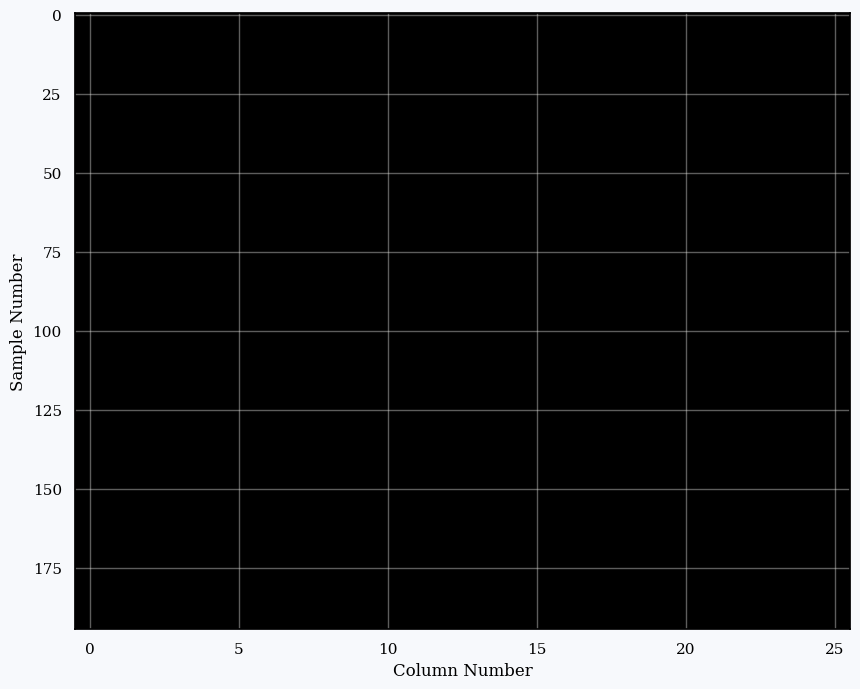

In [239]:
plt.figure(figsize=(10, 8))
plt.imshow(metrics_df.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Sample Number");

It seems like there are no missing values in the dataset.

### Visualizing the distributions (of distributions)

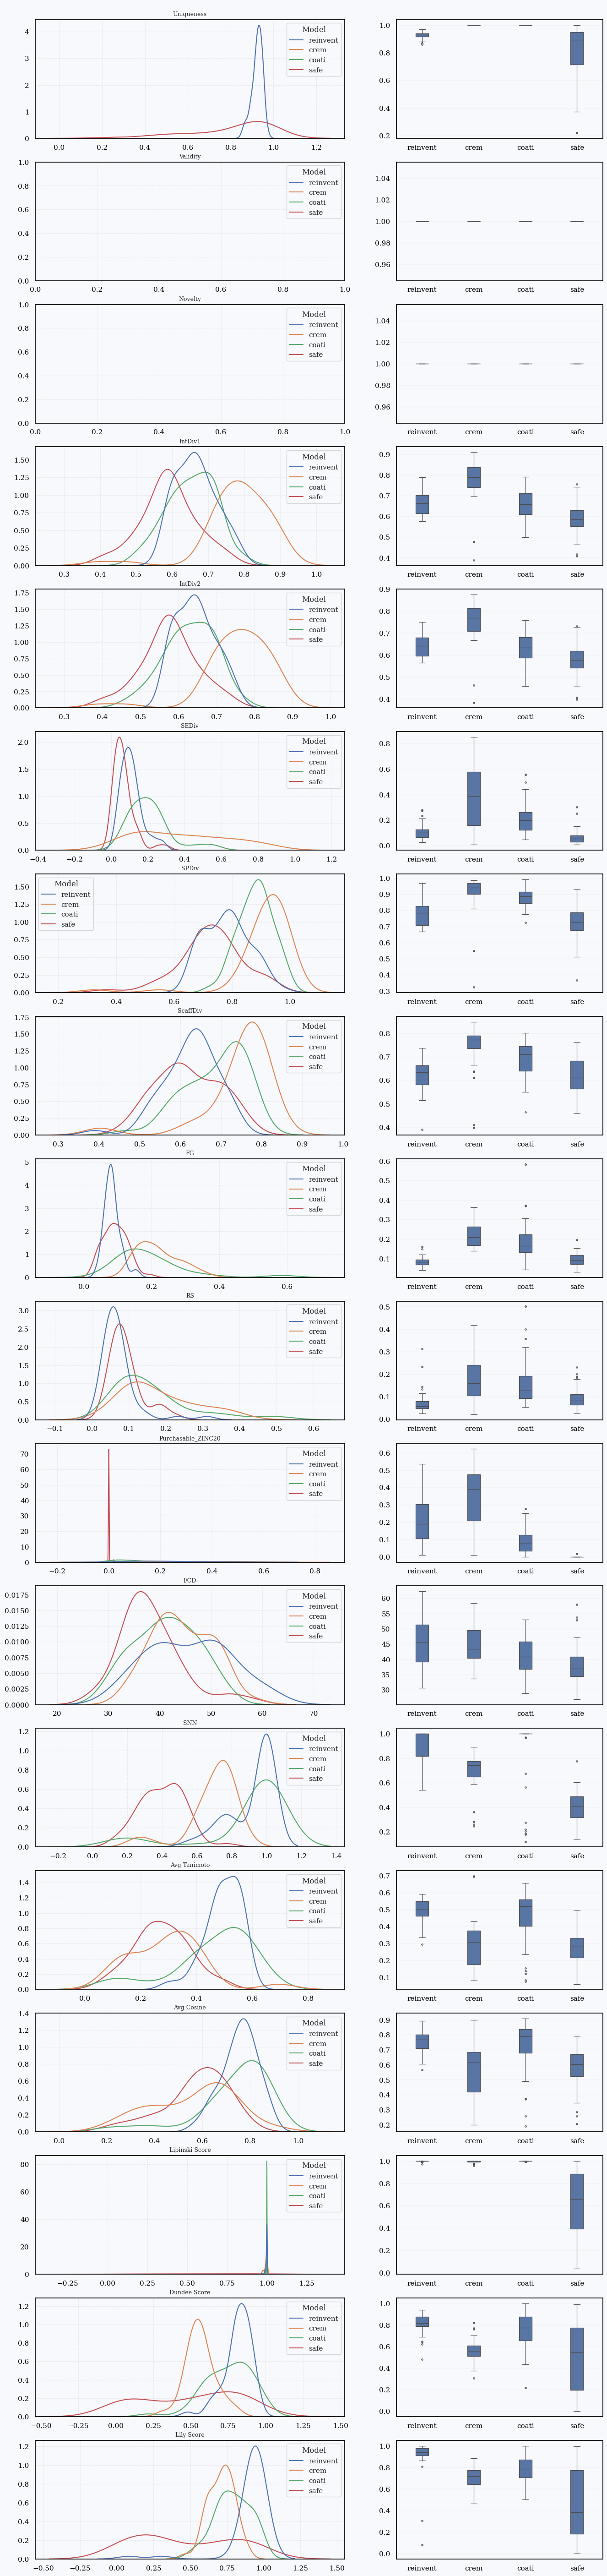

In [240]:
fig, axs = plt.subplots(nrows=len(cols),
                        ncols=2,
                        figsize=(16, len(cols)*4),
                        gridspec_kw={'width_ratios' : [0.6, 0.4]})

for i, col in enumerate(cols):

    ax = axs[i, 0]

    sns.kdeplot(data=metrics_df[[col,'Model']],
                x=col,
                hue='Model',
                warn_singular=False,
                ax=ax)
    
    ax.set_title(f"\n{col}", fontsize = 9)
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
    ax.set(xlabel = '', ylabel = '')
    
    ax = axs[i, 1]

    sns.boxplot(data=metrics_df,
                x = 'Model',
                y=col,
                ax=ax,
                width=0.25,
                linewidth=0.90,
                fliersize=2.25)
    
    ax.set(xlabel = '', ylabel = '')

It seems like the models can be consistently differentiated.

### Assessing correlation

In [241]:
y = metrics_df['Model'].to_numpy().reshape(-1, 1)

In [242]:
enc = OrdinalEncoder()

ord = enc.fit_transform(y)

In [243]:
X = metrics_df[cols]

X['Model'] = ord.squeeze()

In [244]:
# Computes feature correlation
corr = X.corr(method="pearson")

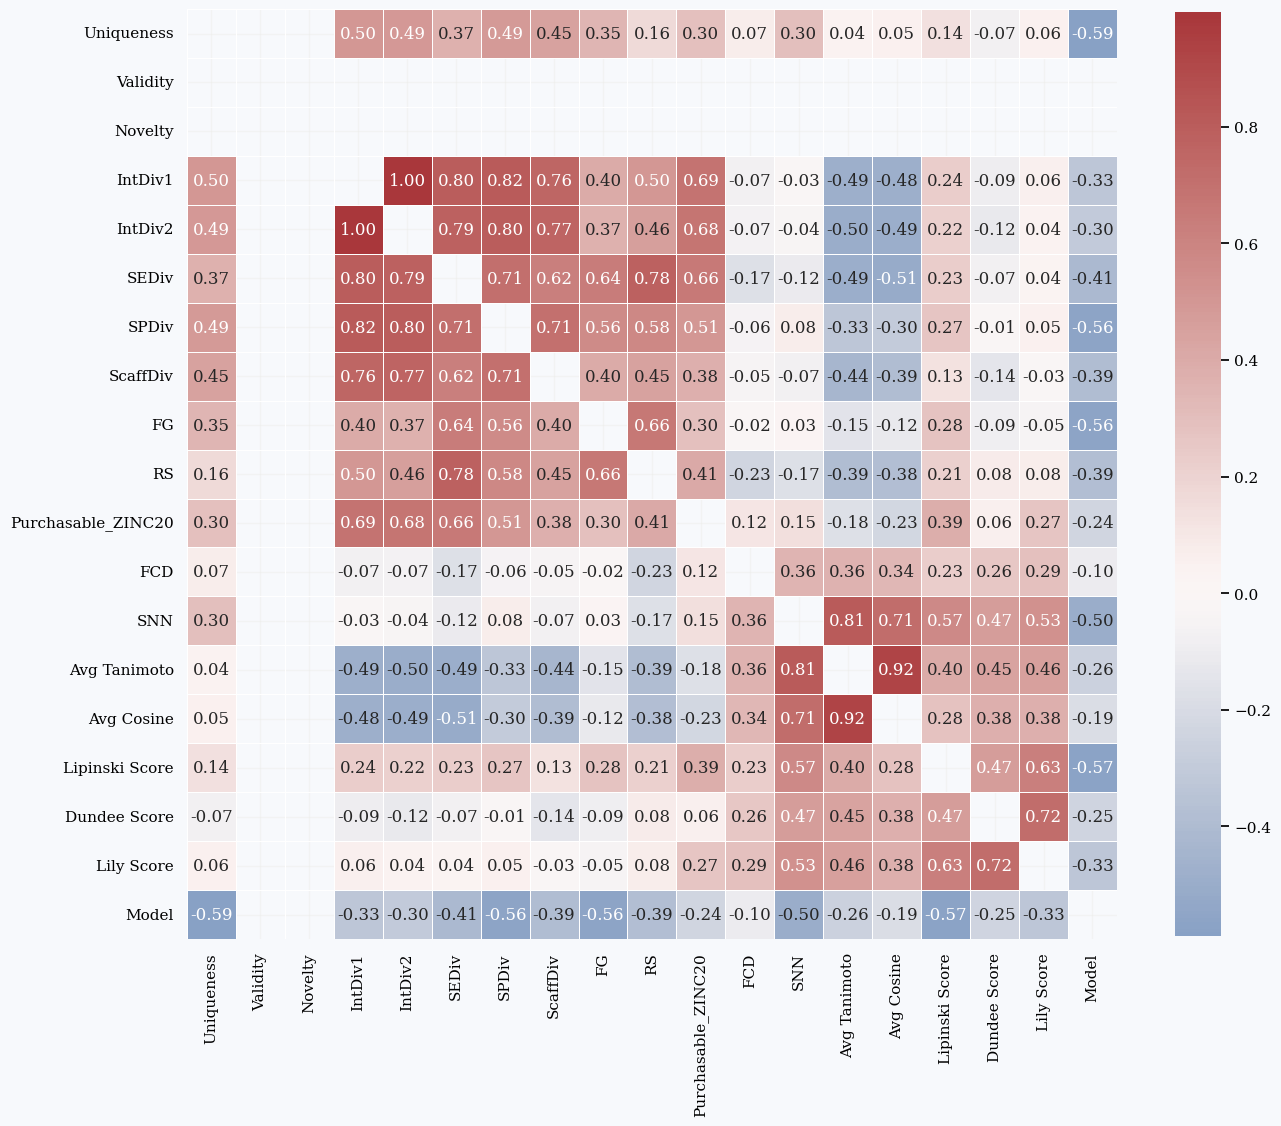

In [245]:
# Create labels for the correlation matrix
labels = np.where(np.abs(corr)>0.75, "S",
                  np.where(np.abs(corr)>0.5, "M",
                           np.where(np.abs(corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr, mask=np.eye(len(corr)), square=True,
            center=0, annot=True, fmt='.2f', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

It's somewhat unsurprising that a lot of the variables are highly correlated, considering the fact that many of them measure similar quantities. Some nontrivial relationships:

 * High correlation between purchasability and internal diversity
 * High correlation between functional group and ring system diversity

## Random Forest Classification

Training a random forest to classify which model generated a given distribution based on the metrics calculated above. Outlined is the methodology:

#### Initial Classification

* Normalize FCD column using min-max scaler
* Train random forest with 100 base estimators and balanced class weights; validate using 5-fold cross-validation
* Compute average precision, recall, and f1-score as well as standard deviations for each across 5 fols
* Fit random forest on entire dataset to determine relative feature importances

#### Classification w/ Feature Selection and Correlation Analysis

### Initial Classification

In [275]:
X = metrics_df.loc[:, cols]
y = metrics_df['Model'].to_numpy().reshape(-1, 1)

In [276]:
X['FCD'] = (X['FCD'] - X['FCD'].min()) / (X['FCD'].max() - X['FCD'].min()) 

In [277]:
enc = OneHotEncoder(handle_unknown='ignore')

In [278]:
enc.fit_transform(y);

In [279]:
rf = RandomForestClassifier(n_estimators=100,
                            class_weight='balanced',
                            random_state=1)

In [280]:
scoring = ['precision_macro', 'recall_macro', 'f1_macro']

In [281]:
scores = cross_validate(rf, X, y, cv=5, scoring=scoring)

In [282]:
avg_precision, precision_std = scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()
avg_recall, recall_std = scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()
avg_f1, f1_std = scores['test_f1_macro'].mean(), scores['test_f1_macro'].std()

In [283]:
print(f"Average Precision: {avg_precision:.3f}, Standard Deviation: {precision_std:.3f}")
print(f"Average Recall: {avg_recall:.3f}, Standard Deviation: {recall_std:.3f}")
print(f"Average F1: {avg_f1:.3f}, Standard Deviation: {f1_std:.3f}")

Average Precision: 0.955, Standard Deviation: 0.036
Average Recall: 0.943, Standard Deviation: 0.052
Average F1: 0.942, Standard Deviation: 0.054


In [257]:
rf.fit(X, y)

RandomForestClassifier(class_weight='balanced', n_estimators=250,
                       random_state=1)

In [260]:
weights = rf.feature_importances_
vars = X.columns

d = {'Features': vars, 'Weights': weights}

rf_features = pd.DataFrame(data=d).sort_values(['Weights'], ascending=False, ignore_index=True)

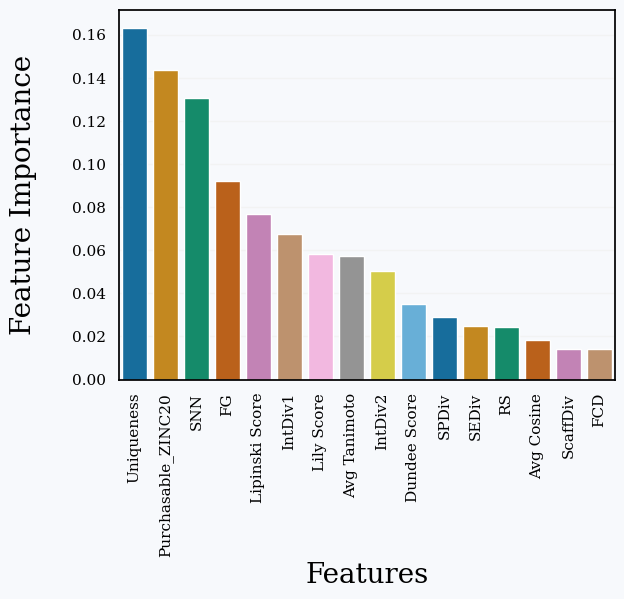

In [261]:
fig, ax = plt.subplots()

sns.barplot(x = 'Features',
			y = 'Weights',
			data = rf_features.loc[:15],
            palette='colorblind',
            ax=ax)

# plt.title('Ranking of Random Forest Features')
ax.set_xlabel('Features', fontsize=20)
ax.set_ylabel('Feature Importance', labelpad=25, fontsize=20)

plt.xticks(rotation=90)

# Show the plot
plt.show()

### Classification w/ Feature Selection and Correlation Analysis

## Scratch